In [2]:
import duckdb

# Caminhos para os bancos de dados
db1_path = 'fineweb.duckdb'  # Substitua pelo caminho do seu primeiro banco de dados
db2_path = 'books.duckdb'  # Substitua pelo caminho do seu segundo banco de dados

# Alias para o segundo banco de dados
alias_db2 = 'db2_alias'

# Conectar ao banco de dados principal
conn = duckdb.connect(database=db1_path, read_only=False)

# Anexar o segundo banco de dados
conn.execute(f"ATTACH DATABASE '{db2_path}' AS {alias_db2}")

# Verificar esquemas (opcional, mas recomendado)
schema_main = conn.execute("DESCRIBE dataset").fetchdf()
schema_db2 = conn.execute(f"DESCRIBE {alias_db2}.dataset").fetchdf()

if not schema_main.equals(schema_db2):
	raise Exception("Os esquemas das tabelas 'dataset' nos dois bancos de dados não são compatíveis.")

# Executar a consulta modificada
df_training = conn.execute(f"""
WITH combined_dataset AS (
    SELECT * FROM dataset
    UNION ALL
    SELECT * FROM {alias_db2}.dataset
),
sampled_a AS (
    SELECT id, indice, content, name
    FROM (
        SELECT
            id,
            indice,
            content,
            name,
            ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
        FROM combined_dataset
    ) sub
    WHERE rn <= 1
),
sampled_b AS (
    SELECT id, indice, content, name
    FROM (
        SELECT
            id,
            indice,
            content,
            name,
            ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
        FROM combined_dataset
    ) sub
    WHERE rn <= 1
)
SELECT
    a.name AS name,
    a.content AS content1,
    b.content AS content2,
    -- Cálculo original do target_transformado
    SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed,
    -- Aplicação da função sigmoide no target_transformado
    1 / (1 + EXP(- (SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice))))) AS target_transformed_sigmoid
FROM sampled_a a
JOIN sampled_b b
    ON a.name = b.name
ORDER BY RANDOM()
LIMIT 50000;
""").df()

conn.close()

df_training

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,name,content1,content2,target_transformed,target_transformed_sigmoid
0,https://norwichcity.myfootballwriter.com/2011/...,dream of playing in it,message this evening as the,7.422971,0.999403
1,http://www.peta2.com/street-team/manders101/?r...,met my doggy sisters. Which,"I like Gymnastics, and I loovvvvee animals! :D...",4.912655,0.992701
2,http://www.koneko.life/life/forget-witches-we-...,are actually painting a picture,Down Under ever again? All,7.693937,0.999545
3,https://www.egypt-uncovered.com/blog/2017/03/1...,The location of the Hotel is also really good ...,"other in Egypt, and is",-8.837246,0.000145
4,https://www.fashionably-yours.com.au/lilly-lux...,be dispatched. There are no reviews yet.Leave ...,allow 14-18 working days,3.688879,0.975610
...,...,...,...,...,...
8698,http://www.tvtechnology.com/prntarticle.aspx?a...,Club in Pittsburgh last week.,NBC and ESPN coverage of the event was capture...,-3.433987,0.031250
8699,https://learning.building.govt.nz/mod/page/vie...,have been taken to ensure the quality and accu...,"Under Section 175 of the Building Act 2004, th...",5.356586,0.995305
8700,http://www.twu.edu/occupational-therapy/10081.asp,document a minimum of 20 contact hours of supe...,"below) in a 9"" x 12"" envelope: • Master of Occ...",-8.209308,0.000272
8701,https://store.trincheronapavalley.com/product/...,is true to its mountain,above sea level in the Vaca Mountains. This cr...,6.274762,0.998120


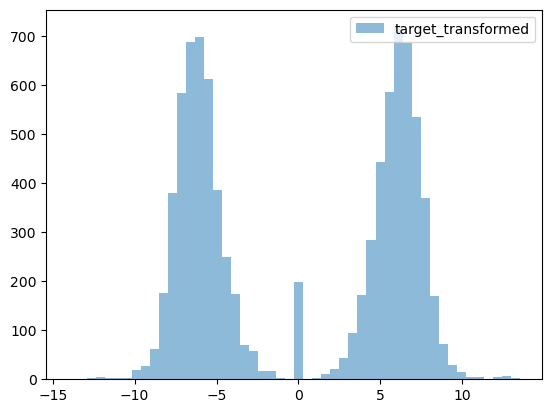

In [3]:
import matplotlib.pyplot as plt

plt.hist(df_training['target_transformed'], bins=50, alpha=0.5, label='target_transformed')
plt.legend()
plt.show()

In [6]:
import torch
import gc

if not torch.cuda.is_available():
    print("CUDA is not available. Please ensure you have a compatible GPU and drivers installed.")
else:
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
import torch
import numpy as np
from transformers import AutoTokenizer
import os

# Disable parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "true"

class TextToEmbedding:
    def __init__(self, weights_path, num_ids=128256, vector_size=2048, device='cpu'):
        """
        Inicializa a classe TextToEmbedding.

        Args:
            tokenizer_name (str): Nome do modelo do tokenizer a ser carregado.
            weights_path (str): Caminho para o arquivo .npy que contém os pesos.
            num_ids (int, opcional): Número total de IDs. Padrão é 128256.
            vector_size (int, opcional): Tamanho de cada vetor de embedding. Padrão é 2048.
            device (str, opcional): Dispositivo para carregar os tensores ('cpu' ou 'cuda'). Padrão é 'cpu'.
        """
        self.device = device

        # Carrega o tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B", legacy=False)
        
        # Carrega os pesos a partir do arquivo .npy
        try:
            weights_np = np.load(weights_path)
            self.weights = torch.from_numpy(weights_np).to(self.device)
        except FileNotFoundError:
            raise FileNotFoundError(f"O arquivo de pesos '{weights_path}' não foi encontrado.")
        except Exception as e:
            raise RuntimeError(f"Erro ao carregar os pesos: {e}")
        
        # Verifica a forma dos pesos
        if self.weights.shape != (num_ids, vector_size):
            raise ValueError(f"O formato do arquivo weights.npy é {self.weights.shape}, mas era esperado {(num_ids, vector_size)}.")

    def text_to_embedding(self, input_text):
        """
        Converte um texto de entrada em seu embedding correspondente.

        Args:
            input_text (str): Texto a ser convertido em embedding.

        Returns:
            torch.Tensor: Tensor contendo os embeddings correspondentes aos IDs do texto.
        """
        # Tokeniza o texto de entrada
        encoding = self.tokenizer(input_text, return_tensors="pt")
        input_ids = encoding.input_ids.to(self.device)
        
        # Assegura que os IDs estão no tipo correto para indexação
        ids_tensor = input_ids.type(torch.long)
        
        # Obtém os embeddings correspondentes aos IDs
        embedding = self.weights[ids_tensor][0]
        
        return embedding
    
embedding_generator = TextToEmbedding("weights_half.npy")

In [3]:
import time
import logging
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

class SequenceDataset_val(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # start_time = time.time()

        row = self.df.iloc[idx]
        sequence1 = embedding_generator.text_to_embedding(row['content1'])
        sequence2 = embedding_generator.text_to_embedding(row['content2'])

        # Use the transformed target
        target = torch.tensor(row['target_transformed'], dtype=torch.float16)

        # Convert sequences to tensors (no need to reconvert embedding)
        #sequence1 = sequence1.float()
        #sequence2 = sequence2.float()

        # end_time = time.time()
        # if idx % 1000 == 0:
        #    logger.info(f"Processing sample {idx}/{len(self.df)} - Time: {end_time - start_time:.4f}s")

        return sequence1, sequence2, target

In [4]:
import torch
from torch.utils.data import IterableDataset, DataLoader
import duckdb
from tqdm import tqdm
import pandas as pd

# Caminhos para os bancos de dados
db1_path = 'fineweb.duckdb'
db2_path = 'books.duckdb'

class InfiniteSequenceDataset(IterableDataset):
    def __init__(self, db1_path, db2_path, batch_size=100):
        super(InfiniteSequenceDataset, self).__init__()
        self.db1_path = db1_path
        self.db2_path = db2_path
        self.batch_size = batch_size

    def _fetch_data(self, conn):
        query = f"""
            WITH combined_dataset AS (
                SELECT * FROM main.dataset
                UNION ALL
                SELECT * FROM db2.dataset
            ),
            sampled_a AS (
                SELECT id, indice, content, name
                FROM (
                    SELECT
                        id,
                        indice,
                        content,
                        name,
                        ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
                    FROM combined_dataset
                ) sub
                WHERE rn <= 1
            ),
            sampled_b AS (
                SELECT id, indice, content, name
                FROM (
                    SELECT
                        id,
                        indice,
                        content,
                        name,
                        ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
                    FROM combined_dataset
                ) sub
                WHERE rn <= 1
            )
            SELECT
                a.name AS name,
                a.content AS content1,
                b.content AS content2,
                SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed
            FROM sampled_a a
            JOIN sampled_b b
                ON a.name = b.name
            ORDER BY RANDOM()
            LIMIT {self.batch_size};
        """
        return conn.execute(query).df()

    def __iter__(self):
        """
        Iterator que gera os dados continuamente.

        Yields:
            tuple: (sequence1, sequence2, target) para cada amostra.
        """
        # Estabelece a conexão com DuckDB
        conn = duckdb.connect(database=self.db1_path, read_only=True)
        conn.execute("SET enable_progress_bar=false")

        # Anexa o segundo banco de dados
        conn.execute(f"ATTACH DATABASE '{self.db2_path}' AS db2")

        try:
            while True:
                df = self._fetch_data(conn)
                for _, row in df.iterrows():
                    sequence1 = embedding_generator.text_to_embedding(row['content1'])
                    sequence2 = embedding_generator.text_to_embedding(row['content2'])

                    target = torch.tensor(row['target_transformed'], dtype=torch.float16)
                    yield sequence1, sequence2, target
        finally:
            # Garante que a conexão seja fechada quando o iterator for finalizado
            conn.close()

In [5]:
import numpy as np

def signed_log_transform(y):
    return np.sign(y) * np.log1p(np.abs(y))

def inverse_signed_log_transform(y_transformed):
    return np.sign(y_transformed) * (np.expm1(np.abs(y_transformed)))

def dissimilaridade(S):
	epsilon = 0
	if S == 0:
		max_x = np.log(np.finfo(np.float32).max)
		epsilon = (1/(max_x-1))
        
	return (1 - (S+epsilon)) / (S+epsilon)

In [6]:
import pandas as pd

data = {
    'target_transformed': [1]*50,
    "content1": ["A tempestade durou várias horas durante a noite.", "Ele estudou intensamente para o exame.", "A fábrica reduziu a emissão de poluentes.", "Maria começou a praticar exercícios regularmente.", "O motor do carro parou de funcionar.", "Houve uma forte seca na região.", "Ela começou a dormir melhor.", "A escola adotou uma alimentação saudável.", "O projeto teve apoio governamental.", "A internet caiu durante a reunião.", "Ele começou a economizar dinheiro mensalmente.", "A estrada estava em péssimo estado de conservação.", "O sistema de ar condicionado foi desligado no escritório.", "A empresa investiu em marketing digital.", "Ana não revisou o relatório antes de enviar.", "As crianças brincaram no parque até tarde.", "O curso de capacitação foi oferecido aos funcionários.", "Ele comprou um celular novo com câmera de alta qualidade.", "A reforma no prédio foi concluída.", "A região teve um crescimento populacional rápido.", "Carla começou a meditar diariamente.", "O atleta intensificou seu treino antes da competição.", "O sinal de celular na região foi ampliado.", "As temperaturas caíram drasticamente durante o inverno.", "Ele não configurou o alarme antes de dormir.", "A empresa ofereceu benefícios extras para seus funcionários.", "Houve um vazamento de gás na cozinha do restaurante.", "A biblioteca da escola foi modernizada com novos livros e tecnologia.", "Marcos passou a fazer pausas regulares durante o expediente.", "A empresa desenvolveu um aplicativo intuitivo para clientes.", "Devido ao aumento das chuvas nas últimas semanas, o nível dos rios subiu rapidamente e ultrapassou a capacidade das barragens.", "Ela decidiu começar uma rotina de alimentação balanceada, exercícios físicos regulares e meditação diária para melhorar sua saúde física e mental.", "A empresa, que sofria com baixos índices de produtividade, implementou uma nova estratégia de gestão focada no desenvolvimento dos funcionários e na cultura organizacional.", "O governo lançou um programa nacional de reciclagem e incentivou a participação ativa dos cidadãos por meio de campanhas de conscientização em escolas, empresas e residências.", "Após uma longa estiagem que afetou grande parte do território agrícola do país, o governo implementou um pacote emergencial de apoio aos agricultores, incluindo subsídios e incentivos para a recuperação das lavouras.", "Ele deixou o celular carregando a noite inteira sem usar carregadores de segurança e em um local sem ventilação.", "A comunidade local se uniu para limpar e revitalizar a praça abandonada, que estava sem manutenção há anos e havia se tornado um ponto de descarte irregular de lixo.", "Durante a reforma do prédio, descobriu-se que a estrutura tinha falhas graves, e o prazo para conclusão foi ampliado em seis meses para garantir a segurança.", "Um furacão atingiu a região costeira do país, com ventos de mais de 200 km/h, causando destruição em várias cidades e deixando milhares de pessoas desabrigadas.", "Ela esqueceu de regar a planta de sua varanda durante o mês todo, e o clima estava seco.", "João quebrou o braço jogando futebol.", "Devido a uma combinação de fatores climáticos extremos, incluindo ventos fortes e chuvas intensas, a região sofreu graves danos estruturais e interrupção no fornecimento de energia elétrica por vários dias.", "Ela esqueceu de levar o guarda-chuva.", "A empresa adotou práticas sustentáveis em sua produção, reduzindo o uso de plástico e implementando programas de reciclagem.", "A criança se recusou a comer legumes durante toda a semana.", "Após anos de pesquisa e desenvolvimento, a equipe científica finalmente descobriu um método eficiente para produzir energia limpa a partir de fontes renováveis.", "O café da manhã foi esquecido.", "A iniciativa comunitária organizou mutirões de limpeza nas praias locais regularmente durante o verão.", "Ele atualizou seu currículo e participou de várias entrevistas de emprego nos últimos meses.", "O artista decidiu experimentar novas técnicas em suas pinturas, incorporando elementos digitais e materiais reciclados em suas obras."],
    "content2": ["Pela manhã, muitas ruas estavam alagadas.", "Conseguiu uma nota alta na prova.", "A qualidade do ar na cidade melhorou.", "Ela perdeu peso e aumentou sua energia.", "Ele teve que chamar o guincho para levar o carro à oficina.", "As plantações foram prejudicadas, e a colheita foi menor.", "Sua disposição durante o dia melhorou significativamente.", "Os alunos passaram a ter mais energia e melhor concentração.", "Conseguiu concluir as fases iniciais rapidamente.", "A comunicação com a equipe foi interrompida.", "Conseguiu juntar uma quantia para uma viagem.", "O trânsito ficou mais lento e perigoso para os motoristas.", "O ambiente ficou quente e desconfortável para os funcionários.", "As vendas aumentaram significativamente.", "O documento continha erros e precisou ser corrigido.", "Elas ficaram cansadas e dormiram rapidamente ao chegar em casa.", "Eles melhoraram suas habilidades e eficiência no trabalho.", "Passou a tirar fotos mais nítidas e de melhor resolução.", "O local ficou mais seguro e esteticamente agradável.", "A demanda por moradias e serviços aumentou consideravelmente.", "Ela sentiu uma melhora no seu foco e redução do estresse.", "Teve um melhor desempenho e conquistou o primeiro lugar.", "A conexão ficou mais estável e acessível para os moradores.", "A procura por agasalhos e cobertores aumentou nas lojas.", "Acabou se atrasando para o trabalho na manhã seguinte.", "A satisfação e motivação dos colaboradores aumentaram.", "O local foi evacuado por segurança, e o serviço foi interrompido temporariamente.", "Os alunos começaram a frequentá-la mais e a melhorar seu desempenho acadêmico.", "Ele se sentiu mais produtivo e menos cansado ao final do dia.", "O número de usuários aumentou rapidamente.", "Diversas áreas urbanas e rurais foram afetadas por inundações, forçando muitas famílias a deixarem suas casas temporariamente.", "Em poucos meses, notou uma grande melhora em sua disposição, concentração e níveis de energia, além de perder peso.", "Em menos de um ano, a moral da equipe melhorou, a rotatividade diminuiu, e a produtividade geral aumentou em cerca de 30%.", "Como resultado, houve uma redução significativa na quantidade de resíduos sólidos em aterros e uma maior economia de recursos naturais.", "Em um ano, a produção agrícola voltou a níveis estáveis, e o impacto econômico negativo foi mitigado, beneficiando a população.", "Pela manhã, o dispositivo estava superaquecido e apresentou danos permanentes na bateria, reduzindo sua capacidade de funcionamento.", "Com a revitalização, a praça voltou a ser um local de encontro para moradores, e a segurança da área também melhorou.", "Apesar do atraso, a reforma resultou em um edifício mais seguro, confortável e com um aumento significativo no valor do imóvel.", "A resposta emergencial foi mobilizada rapidamente, com abrigos temporários e ajuda humanitária distribuída para minimizar o impacto nas vítimas.", "A planta murchou completamente e, infelizmente, não conseguiu ser recuperada, tendo que ser substituída.", "Ele ficou impossibilitado de trabalhar por duas semanas.", "A comunidade teve que recorrer a abrigos temporários, e a economia local sofreu uma queda significativa devido à paralisação das atividades comerciais.", "Ficou molhada durante o trajeto para o trabalho.", "A reputação da empresa melhorou, atraindo consumidores conscientes e aumentando as vendas em 20%.", "Sua mãe ficou preocupada com a falta de nutrientes na alimentação dele e decidiu consultar um nutricionista.", "Isso resultou na redução significativa das emissões de carbono e no avanço tecnológico sustentável, beneficiando o meio ambiente globalmente.", "Ela sentiu fome e falta de energia durante a manhã de trabalho.", "As praias ficaram mais limpas e atraentes para turistas, além de promover a conscientização ambiental entre os moradores.", "Finalmente recebeu uma oferta de trabalho em uma empresa renomada, melhorando sua estabilidade financeira.", "Suas peças ganharam destaque em exposições internacionais, ampliando seu reconhecimento e alcance no mercado de arte."]
}

# Crie o DataFrame
df_validation = pd.DataFrame(data)

# Adicionar frases iguais
df_zero = pd.DataFrame({
    'target_transformed': [0] * len(data['target_transformed']),
    'content1': df_validation['content1'],
    'content2': df_validation['content1']
})

# Adicionar frases com a ordem contrária
df_reversed = pd.DataFrame({
    'target_transformed': [-1] * len(data['target_transformed']),
    'content1': df_validation['content2'],
    'content2': df_validation['content1']
})

# Concatenar os dois DataFrames
df_validation = pd.concat([df_zero, df_validation, df_reversed], ignore_index=True)

df_validation

,target_transformed,content1,content2
0,0,A tempestade durou várias horas durante a noite.,A tempestade durou várias horas durante a noite.
1,0,Ele estudou intensamente para o exame.,Ele estudou intensamente para o exame.
2,0,A fábrica reduziu a emissão de poluentes.,A fábrica reduziu a emissão de poluentes.
3,0,Maria começou a praticar exercícios regularmente.,Maria começou a praticar exercícios regularmente.
4,0,O motor do carro parou de funcionar.,O motor do carro parou de funcionar.
...,...,...,...
145,-1,Isso resultou na redução significativa das emi...,"Após anos de pesquisa e desenvolvimento, a equ..."
146,-1,Ela sentiu fome e falta de energia durante a m...,O café da manhã foi esquecido.
147,-1,As praias ficaram mais limpas e atraentes para...,A iniciativa comunitária organizou mutirões de...
148,-1,Finalmente recebeu uma oferta de trabalho em u...,Ele atualizou seu currículo e participou de vá...


In [7]:
# Função para o collate_fn, necessária para lidar com sequências de tamanhos variáveis
def collate_fn(batch):
    sequences1, sequences2, targets = zip(*batch)
    return sequences1, sequences2, torch.stack(targets)

In [ ]:
batch_size = 100

training_dataset = InfiniteSequenceDataset(db1_path, db2_path)
train_dataloader = DataLoader(
  training_dataset, 
  batch_size=batch_size, 
  num_workers=1,
  collate_fn=collate_fn
)

validation_dataset = SequenceDataset_val(df_validation)
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=150,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn
)

In [9]:
import torch
import torch.nn as nn

class RegressionRNN(nn.Module):
    def __init__(self, input_size=2048, hidden_size=128, num_layers=3):
        super(RegressionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True

        # Definição dos RNNs bidirecionais
        self.rnn1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=0.1
        )

        self.rnn2 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=0.1
        )

        # Tamanho final após concatenar as saídas bidirecionais
        final_hidden_size = hidden_size * 4  # (hidden_size * 2) * 2

        # Camadas totalmente conectadas
        self.fc1 = nn.Linear(final_hidden_size, 64)
        self.leaky_relu = nn.LeakyReLU()

        self.fc2 = nn.Linear(64, 1)

    def _process_sequences(self, sequences, rnn):
        lengths = torch.tensor(
            [seq.size(0) for seq in sequences], dtype=torch.long, device=sequences[0].device)

        padded_sequences = nn.utils.rnn.pad_sequence(
            sequences, batch_first=True)

        packed_input = nn.utils.rnn.pack_padded_sequence(
            padded_sequences,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        packed_output, (h_n, _) = rnn(packed_input)

        h_n_forward = h_n[-2, :, :]
        h_n_backward = h_n[-1, :, :]

        combined = torch.cat((h_n_forward, h_n_backward), dim=1)

        return combined

    def forward(self, sequences1, sequences2):
        last_output1 = self._process_sequences(sequences1, self.rnn1)
        last_output2 = self._process_sequences(sequences2, self.rnn2)

        combined_output = torch.cat((last_output1, last_output2), dim=1)

        out = self.fc1(combined_output)
        # Remova ou altere a ativação
        # out = self.relu(out)
        out = self.leaky_relu(out)

        out = self.fc2(out)

        return out.squeeze(1)

In [10]:
# Inicializa o modelo, critério de perda e otimizador
model_order = RegressionRNN().to('cuda').half() 
#criterion = nn.MSELoss()
criterion = nn.HuberLoss()

In [11]:
optimizer = torch.optim.Adam(
    model_order.parameters(), lr=0.1, weight_decay=1e-6)

# Inicializar o scheduler ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1, verbose=True
)

In [12]:
# Inicializar o contador de passos
step = 0
steps_per_epoch = 10  # Número de batches por época
validation_steps = None  # Se você deseja limitar os passos de validação, defina um número inteiro

In [13]:
num_epochs = 2000

In [14]:
from torch.utils.tensorboard import SummaryWriter

2024-11-24 10:15:05.812098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 10:15:06.089569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732454106.200196    4678 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732454106.229021    4678 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 10:15:06.513293: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [15]:
# Inicializar o writer do TensorBoard
writer = SummaryWriter('runs/treinamento_regressao_rnn')

# Envolver o loop de épocas com tqdm para mostrar o progresso das épocas
epoch_progress = tqdm(range(num_epochs), desc='Treinamento', unit='época')

for epoch in epoch_progress:
	epoch_progress.set_description(f'Época {epoch+1}/{num_epochs}')

	# Treinamento
	model_order.train()
	train_loss = 0.0

	# Criar um iterador a partir do dataloader
	train_iterator = iter(train_dataloader)

	# Usar tqdm para o progresso dentro da época
	batch_progress = tqdm(range(steps_per_epoch), desc='Treinando', leave=False, unit='batch')

	for _ in batch_progress:
		try:
			sequences1_batch, sequences2_batch, targets_batch = next(train_iterator)
		except StopIteration:
			# Reiniciar o iterador se necessário
			train_iterator = iter(train_dataloader)
			sequences1_batch, sequences2_batch, targets_batch = next(train_iterator)

		# Mover as sequências para a GPU sem empilhar
		sequences1_batch = [s.to('cuda') for s in sequences1_batch]
		sequences2_batch = [s.to('cuda') for s in sequences2_batch]
		# Alvos já estão empilhados e devem ser movidos para a GPU
		targets_batch = targets_batch.to('cuda')

		optimizer.zero_grad()
		# Forward pass
		outputs = model_order(sequences1_batch, sequences2_batch)
		loss = criterion(outputs, targets_batch)

		# Backward pass e otimização
		loss.backward()
		optimizer.step()

		train_loss += loss.item() * targets_batch.size(0)

		# Registrar a perda de treinamento a cada passo
		writer.add_scalar('Perda_Treinamento_Passo', loss.item(), step)
		step += 1

		# Atualizar a descrição do progresso do batch
		batch_progress.set_postfix({'Perda Passo': f'{loss.item():.4f}'})

	# Calcular a perda média de treinamento para a época
	avg_train_loss = train_loss / (steps_per_epoch * batch_size)

	# Validação
	model_order.eval()
	validation_loss = 0.0
	correct_sign = 0
	total = 0

	with torch.no_grad():
		for sequences1_batch, sequences2_batch, targets_batch in validation_dataloader:
			# Mover as sequências para a GPU sem empilhar
			sequences1_batch = [s.to('cuda') for s in sequences1_batch]
			sequences2_batch = [s.to('cuda') for s in sequences2_batch]
			# Alvos já estão empilhados e devem ser movidos para a GPU
			targets_batch = targets_batch.to('cuda')

			# Forward pass
			outputs = model_order(sequences1_batch, sequences2_batch)
			loss = criterion(outputs, targets_batch)
			validation_loss += loss.item() * targets_batch.size(0)

			# Lógica de comparação
			matches = (
				((targets_batch == -1) & (outputs < -1.71)) |  # Regra para -1
				((targets_batch == 0) & ((-1.71 < outputs) & (outputs < 1.71))) |  # Regra para 0
				((targets_batch == 1) & (1.71 < outputs))     # Regra para 1
			)

			total += matches.float().mean()

	sign_accuracy = total / len(validation_dataloader.dataset)

	# Calcular a perda média de validação para a época
	avg_validation_loss = validation_loss / len(validation_dataloader.dataset)

	# Registrar as métricas de validação por época
	writer.add_scalar('Perda_Validação_Epoca', avg_validation_loss, epoch+1)
	writer.add_scalar('Acurácia_Sinal_Validação', sign_accuracy, epoch+1)

	# Passar a perda de validação para o scheduler
	scheduler.step(avg_validation_loss)

	# Registrar a taxa de aprendizado atual (opcional)
	current_lr = optimizer.param_groups[0]['lr']
	writer.add_scalar('Taxa_Aprendizado', current_lr, epoch+1)

	# Atualizar a descrição da barra com as perdas atuais e acurácia do sinal
	epoch_progress.set_postfix({
		'Perda Treinamento': f'{avg_train_loss:.3f}',
		'Perda Validação': f'{avg_validation_loss:.3f}',
		'Acurácia Sinal': f'{sign_accuracy*100:.2f}%',
		'LR': f'{current_lr:.8f}'
	})

	# Liberar cache da GPU após cada época
	torch.cuda.empty_cache()

# Fechar o SummaryWriter ao final do treinamento
writer.close()

Época 21/2000:   1%|          | 20/2000 [13:22<22:03:45, 40.11s/época, Perda Treinamento=nan, Perda Validação=nan, Acurácia Sinal=0.00%, LR=0.00009766]


KeyboardInterrupt: 

In [ ]:
import os

# Diretório onde os modelos serão salvos
save_dir = './saved_fineweb2'
os.makedirs(save_dir, exist_ok=True)

# Salvando o estado do modelo
model_path = os.path.join(save_dir, 'regression_rnn_model.pth')
torch.save(model_order.state_dict(), model_path)
print(f"Modelo salvo em {model_path}")

# Opcional: Salvando o estado do otimizador
optimizer_path = os.path.join(save_dir, 'optimizer_state.pth')
torch.save(optimizer.state_dict(), optimizer_path)
print(f"Estado do otimizador salvo em {optimizer_path}")

# Opcional: Salvar a época atual para retomar o treinamento
epoch_path = os.path.join(save_dir, 'last_epoch.pth')
torch.save({'epoch': epoch, 'model_state_dict': model_order.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_validation_loss}, epoch_path)
print(f"Checkpoint salvo em {epoch_path}")

Modelo salvo em ./saved_fineweb/regression_rnn_model.pth
Estado do otimizador salvo em ./saved_fineweb/optimizer_state.pth
Checkpoint salvo em ./saved_fineweb/last_epoch.pth


In [17]:
import os
model_path = os.path.join('./saved_fineweb', 'regression_rnn_model.pth')

# Carregar o estado do modelo
model_order.load_state_dict(torch.load(model_path, map_location='cuda'))

# Colocar o modelo em modo de avaliação
#model_order.eval()

/tmp/ipykernel_5480/1341147546.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_order.load_state_dict(torch.load(model_path, map_location='cuda'))


<All keys matched successfully>

In [20]:
model_order.eval()

sequences1 = [text_to_embedding(text).to('cuda') for text in df_validation['content1']]
sequences2 = [text_to_embedding(text).to('cuda') for text in df_validation['content2']]
targets_batch = targets_batch.to('cuda')

# Realizar a previsão
with torch.no_grad():
	output = model_order(sequences1, sequences2)

	matches = (
		((targets_batch == -1) & (outputs < -1.71)) |  # Regra para -1
		((targets_batch == 0) & ((-1.71 < outputs) & (outputs < 1.71))) |  # Regra para 0
		((targets_batch == 1) & (1.71 < outputs))     # Regra para 1
	)

print(matches.float().mean())
	
# Imprimir os resultados da previsão
for i, pred in enumerate(output):
	print(f"Resultado da previsão para o par {i+1}: {pred.item()}")

tensor(0.3267, device='cuda:0')
Resultado da previsão para o par 1: -3.3632216453552246
Resultado da previsão para o par 2: -3.7156126499176025
Resultado da previsão para o par 3: -4.832218647003174
Resultado da previsão para o par 4: -4.3761887550354
Resultado da previsão para o par 5: -2.979902505874634
Resultado da previsão para o par 6: -3.6052279472351074
Resultado da previsão para o par 7: -3.2769346237182617
Resultado da previsão para o par 8: -4.876284122467041
Resultado da previsão para o par 9: -3.826033115386963
Resultado da previsão para o par 10: -3.756565809249878
Resultado da previsão para o par 11: -4.249359607696533
Resultado da previsão para o par 12: -4.437362194061279
Resultado da previsão para o par 13: -3.0058093070983887
Resultado da previsão para o par 14: -2.8122048377990723
Resultado da previsão para o par 15: -4.205542087554932
Resultado da previsão para o par 16: -4.065101623535156
Resultado da previsão para o par 17: -1.3755769729614258
Resultado da previsã

In [21]:
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Listas para armazenar as pontuações reais e as previsões do modelo
true_scores = []
pred_scores = []

with torch.no_grad():
    for example in eval_dataset:
        sent1 = example['sentence1']
        sent2 = example['sentence2']
        score = example['score']

        # Gerar embeddings para ambas as sentenças
        embedding1 = text_to_embedding(sent1).to('cuda')
        embedding2 = text_to_embedding(sent2).to('cuda')

        # Obter a previsão do modelo
        prediction = model_order([embedding1], [embedding2])
        pred_score = 1 / (1 + abs(prediction.item()))

        # Armazenar as pontuações
        true_scores.append(score)
        pred_scores.append(pred_score)

# Calcular as métricas de correlação
pearson_corr, _ = pearsonr(true_scores, pred_scores)
spearman_corr, _ = spearmanr(true_scores, pred_scores)

print("Similaridade Inversa da Diferença Absoluta")
print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")

Similaridade Inversa da Diferença Absoluta
Correlação de Pearson: 0.1258
Correlação de Spearman: 0.1279


In [22]:
import torch
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm  # Para acompanhar o progresso

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Definir o intervalo de valores de k a serem testados
k_values = np.arange(0.001, 100.0, 0.01)
best_k = None
best_pearson = -1  # Inicialização com um valor baixo
best_spearman = -1

# Pré-computar todas as predições para evitar recalcular múltiplas vezes
true_scores = []
predictions = []

with torch.no_grad():
    for example in tqdm(eval_dataset, desc="Processando exemplos"):
        sent1 = example['sentence1']
        sent2 = example['sentence2']
        score = example['score']

        # Gerar embeddings para ambas as sentenças
        embedding1 = text_to_embedding(sent1).to('cuda')
        embedding2 = text_to_embedding(sent2).to('cuda')

        # Obter a previsão do modelo
        prediction = model_order([embedding1], [embedding2])
        predictions.append(prediction.item())

        # Armazenar as pontuações reais
        true_scores.append(score)

true_scores = np.array(true_scores)
predictions = np.array(predictions)

# Iterar sobre os valores de k para encontrar o melhor
for k in tqdm(k_values, desc="Buscando o melhor k"):
    pred_scores = np.exp(-k * np.abs(predictions))
    
    pearson_corr, _ = pearsonr(true_scores, pred_scores)
    spearman_corr, _ = spearmanr(true_scores, pred_scores)
    
    # Verificar se este k é o melhor até agora
    if pearson_corr > best_pearson:
        best_pearson = pearson_corr
        best_spearman = spearman_corr
        best_k = k

print("Similaridade Baseada em Exponencial")
print(f"Melhor valor de k: {best_k}")
print(f"Correlação de Pearson: {best_pearson:.4f}")
print(f"Correlação de Spearman: {best_spearman:.4f}")

Buscando o melhor k: 100%|██████████| 10000/10000 [00:18<00:00, 545.96it/s]

Similaridade Baseada em Exponencial
Melhor valor de k: 0.4609999999999999
Correlação de Pearson: 0.1268
Correlação de Spearman: 0.1279


In [ ]:
import os
import torch
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr

# Verificar se CUDA está disponível
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Carregar o modelo SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2").to(device)

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Listas para armazenar as pontuações reais e as previsões do modelo
true_scores = []
pred_scores = []

# Obter as sentenças e os escores do conjunto de dados
sentences1 = eval_dataset['sentence1']
sentences2 = eval_dataset['sentence2']
scores = eval_dataset['score']

# Processar uma frase por vez
for i in range(len(eval_dataset)):
    sentence1 = sentences1[i]
    sentence2 = sentences2[i]
    true_score = scores[i]

    # Gerar embeddings para ambas as sentenças individualmente
    embedding1 = model.encode(sentence1, convert_to_tensor=True, device=device, show_progress_bar=False)
    embedding2 = model.encode(sentence2, convert_to_tensor=True, device=device, show_progress_bar=False)

    # Calcular a similaridade cosseno
    cosine_score = util.cos_sim(embedding1, embedding2).item()

    # Escalar a similaridade cosseno de [-1, 1] para [0, 1]
    scaled_score = (cosine_score + 1) / 2

    # Armazenar as pontuações
    true_scores.append(true_score)
    pred_scores.append(scaled_score)

# Calcular as métricas de correlação
pearson_corr, _ = pearsonr(true_scores, pred_scores)
spearman_corr, _ = spearmanr(true_scores, pred_scores)

print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")

In [ ]:
import os
model_path = os.path.join('./saved_HuberLoss', 'regression_rnn_model.pth')

# Carregar o estado do modelo
#model_order.load_state_dict(torch.load(model_path, map_location='cuda'))

# Colocar o modelo em modo de avaliação
model_order.eval()

# Realizar a previsão
with torch.no_grad():
    output = model_order(
        [text_to_embedding(
            "O aluno estudou para o exame durante a noite.").to('cuda')],
        [text_to_embedding("O resultado foi excelente devido à dedicação.").to('cuda')])

# Imprimir a saída da regressão
print("Resultado da previsão:", output.item())

In [ ]:
del model_order  # Remove a referência ao modelo

# Libera a memória da GPU, se o modelo estiver usando CUDA
torch.cuda.empty_cache()

# Força a coleta de lixo
gc.collect()